In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(1, "../..")
from itertools import product
from prototype_nn import Splitting, predictions, tensor_flatten
import matplotlib.pyplot as plt
import prototype
import torch
%run ../utilities.ipynb

## Training : Simulations

In [2]:
training = pd.DataFrame(data = pd.read_csv("../../data/train/bouncing.csv"))
training.head()

,time,initial_position,initial_velocity,position,velocity
0,0.0,10,16,10.0000,16.000
1,0.1,10,16,11.6000,15.019
2,0.2,10,16,13.1019,14.038
3,0.3,10,16,14.5057,13.057
4,0.4,10,16,15.8114,12.076


In [3]:
len(training)

20002

In [4]:
training["initial_parameters"] = list(zip(training.initial_position, training.initial_velocity))
training.head()

,time,initial_position,initial_velocity,position,velocity,initial_parameters
0,0.0,10,16,10.0000,16.000,"(10, 16)"
1,0.1,10,16,11.6000,15.019,"(10, 16)"
2,0.2,10,16,13.1019,14.038,"(10, 16)"
3,0.3,10,16,14.5057,13.057,"(10, 16)"
4,0.4,10,16,15.8114,12.076,"(10, 16)"


In [5]:
initial = training[training["initial_parameters"] == (10,16)]

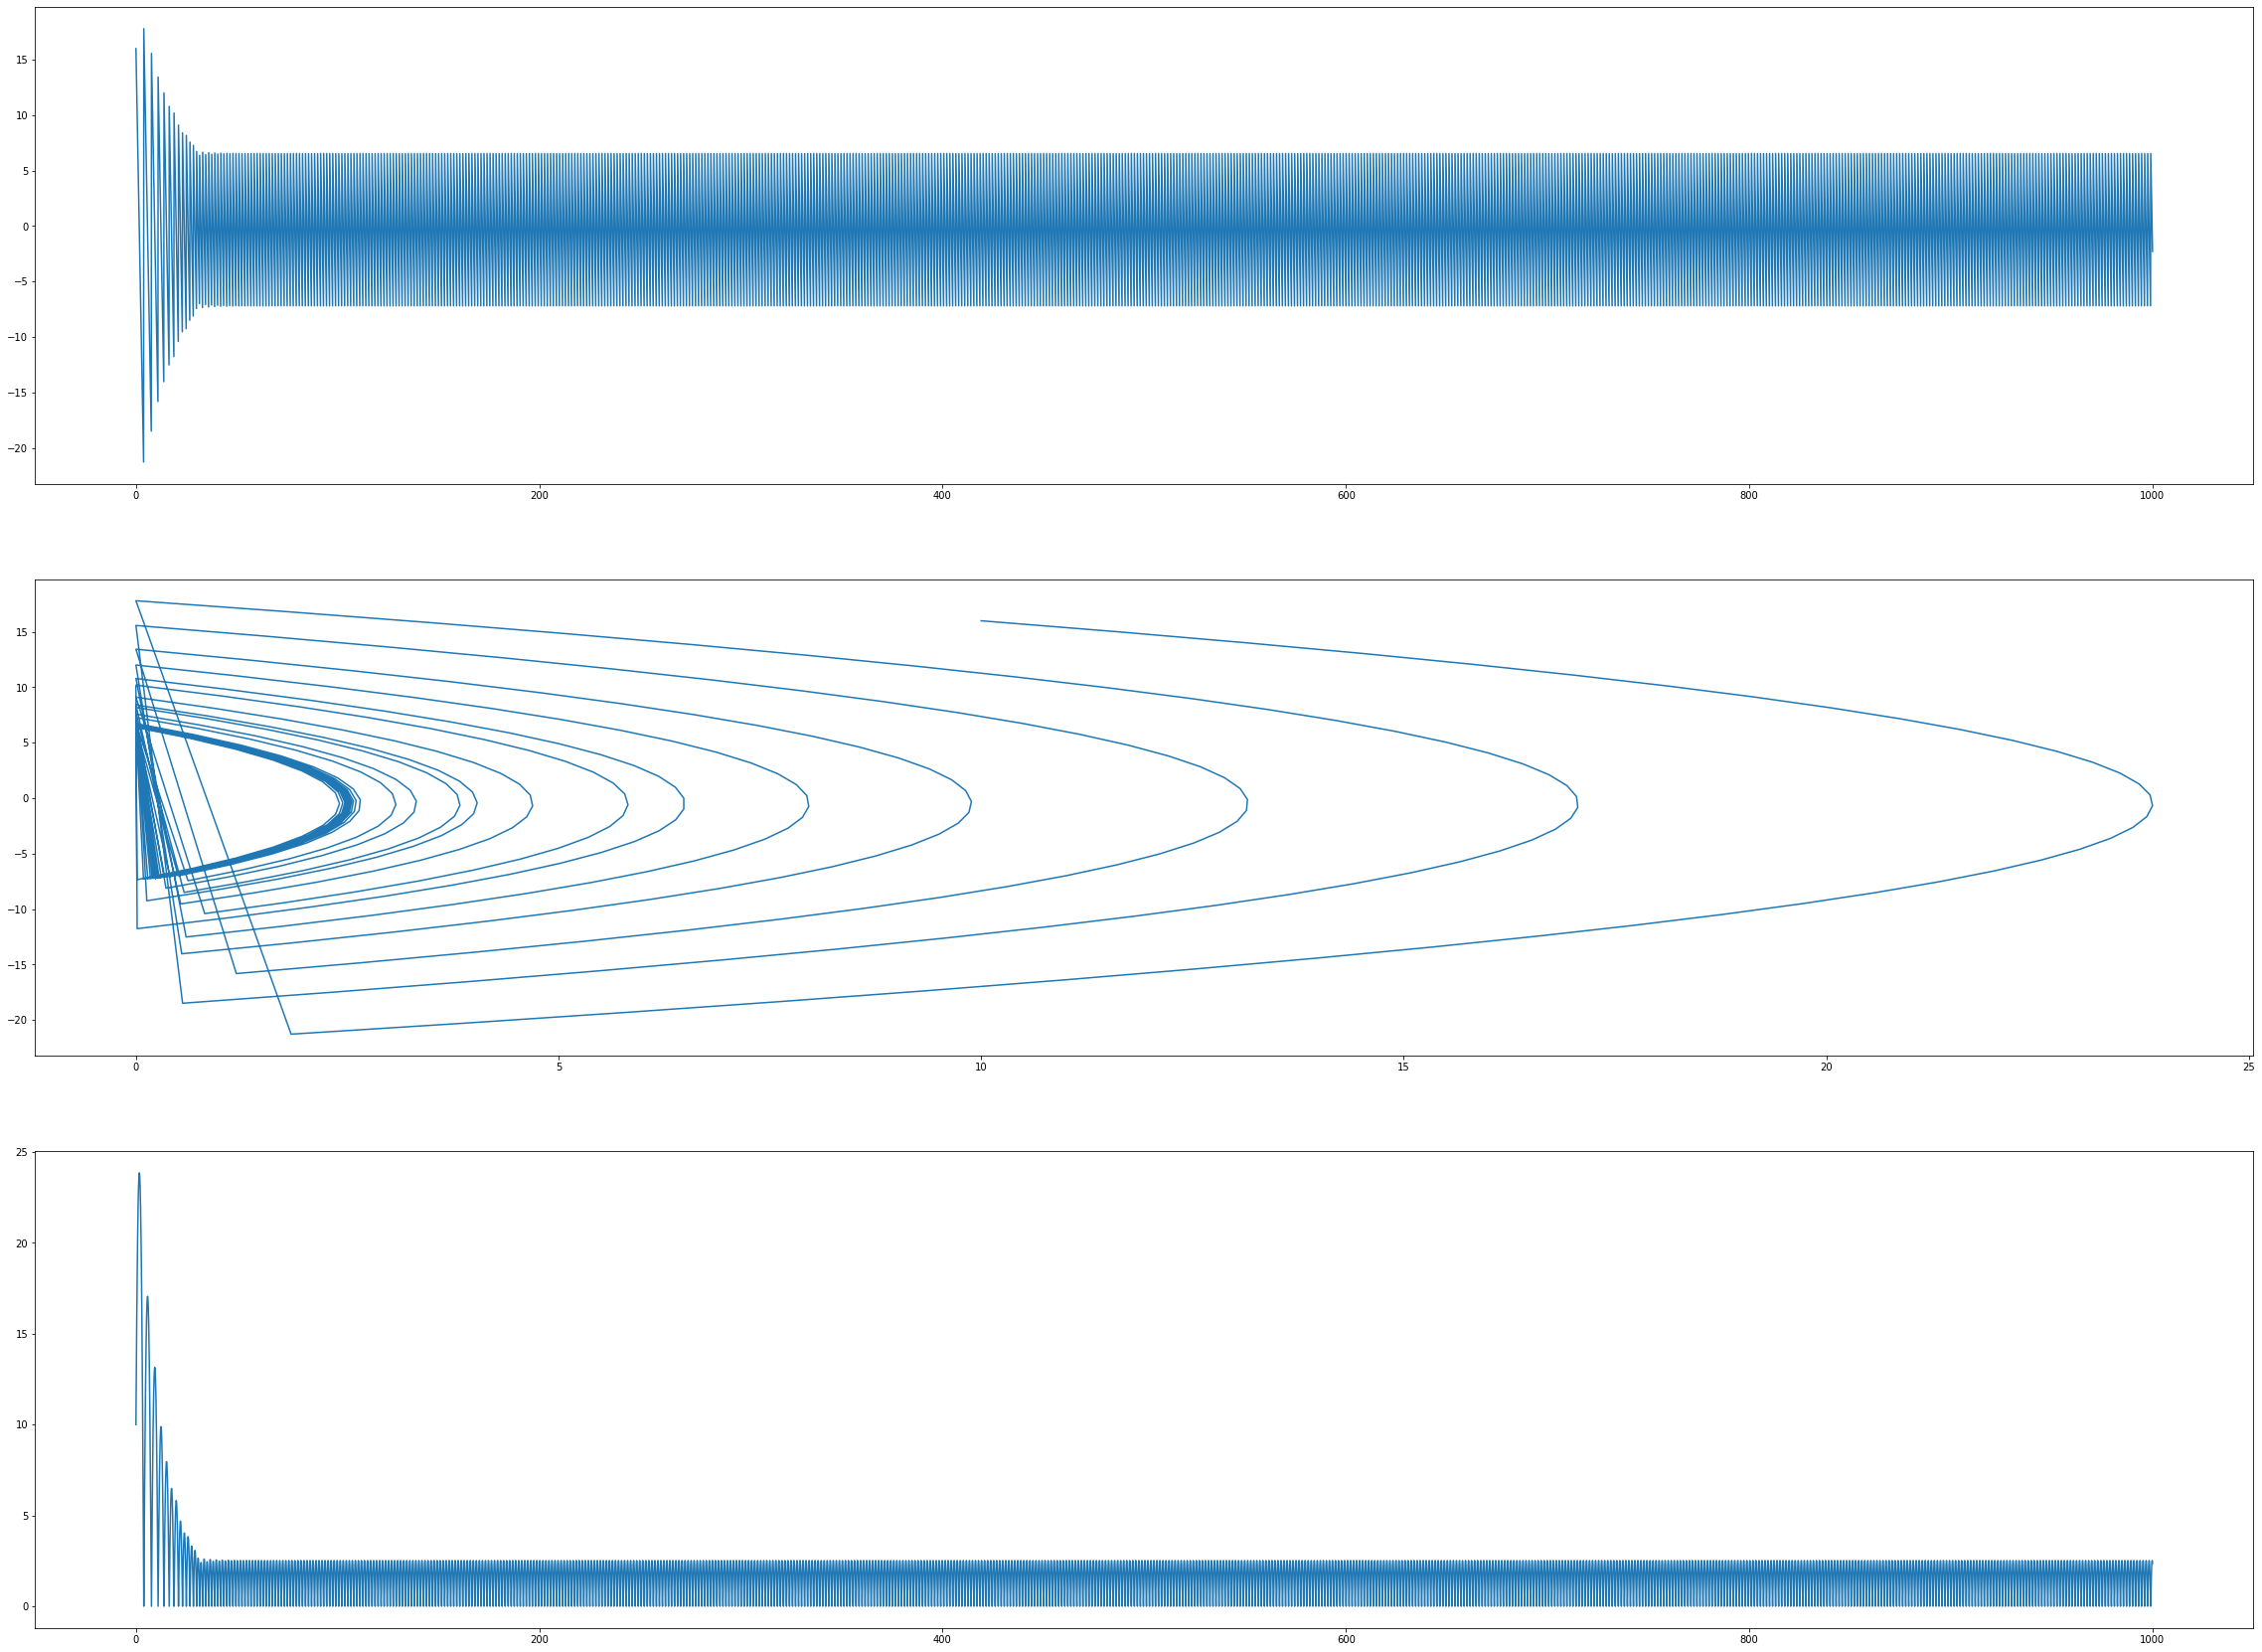

In [10]:
fig, ax = plt.subplots(nrows = 3, figsize=(40,30))
ax[0].plot(initial[["time"]], initial[["velocity"]])
ax[1].plot(initial[["position"]], initial[["velocity"]])
ax[2].plot(initial[["time"]], initial[["position"]])

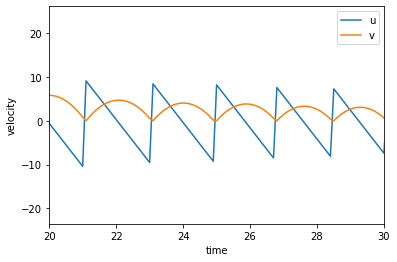

In [67]:
fig, ax = plt.subplots()
sns.lineplot(data = initial, x = "time", y = "velocity", ax = ax,label = "u")
sns.lineplot(data = initial, x = "time", y = "position", ax=ax, label = "v")
ax.set_xlim(20,30)
ax.legend()

In [8]:
kfold = Splitting([0,1,2,4], [3,4], num_epoches = 20, batch_size = 64, lr= 0.0001)

In [9]:
evaluate = kfold.cross_validation_evaluate(training, 5)

------------- Fold 0 -------------
TEST: 0 TRAIN: [1, 2, 3, 4]
Epoch: 0  Train Loss: 2.6937320232391357 
Epoch: 1  Train Loss: 2.2535738945007324 
Epoch: 2  Train Loss: 0.020845048129558563 
Epoch: 3  Train Loss: 0.2141207605600357 
Epoch: 4  Train Loss: 0.038311444222927094 


KeyboardInterrupt: 

In [9]:
evaluate

[tensor(0.0134, grad_fn=<MseLossBackward>),
 tensor(1.1305, grad_fn=<MseLossBackward>),
 tensor(0.0302, grad_fn=<MseLossBackward>),
 tensor(0.0197, grad_fn=<MseLossBackward>),
 tensor(0.0292, grad_fn=<MseLossBackward>)]

In [10]:
average_loss = 0
for x in evaluate:
    average_loss += x.item()
average_loss/len(evaluate)

0.2445920305326581

## Training : Predictions

In [12]:
training_preds = pd.DataFrame(data = pd.read_csv("../../data/preds/train/bouncing.csv"))
training_preds.head()

,time,initial_position,initial_velocity,position,velocity
0,0.0,10,16,8.820866,15.906994
1,0.1,10,16,10.712911,14.990959
2,0.2,10,16,12.514177,14.031652
3,0.3,10,16,14.075670,13.049877
4,0.4,10,16,15.342287,12.080115


In [13]:
len(training_preds)

20002

In [14]:
training_preds["initial_parameters"] = list(zip(training_preds.initial_position, training_preds.initial_velocity))
training_preds = training_preds.drop(columns = ["initial_position", "initial_velocity"])
training = training.drop(columns = ["initial_position", "initial_velocity"])
training_preds = training_preds.rename(columns={
                                            'position' : 'position_preds',
                                            'velocity' : 'velocity_preds'})

In [15]:
training_preds.head()

,time,position_preds,velocity_preds,initial_parameters
0,0.0,8.820866,15.906994,"(10, 16)"
1,0.1,10.712911,14.990959,"(10, 16)"
2,0.2,12.514177,14.031652,"(10, 16)"
3,0.3,14.075670,13.049877,"(10, 16)"
4,0.4,15.342287,12.080115,"(10, 16)"


In [16]:
len(training_preds)

20002

In [17]:
training.head()

,time,position,velocity,initial_parameters
0,0.0,10.0000,16.000,"(10, 16)"
1,0.1,11.6000,15.019,"(10, 16)"
2,0.2,13.1019,14.038,"(10, 16)"
3,0.3,14.5057,13.057,"(10, 16)"
4,0.4,15.8114,12.076,"(10, 16)"


In [18]:
training_and_predictions = pd.merge(training, training_preds, right_on=["time", "initial_parameters"], left_on=["time", "initial_parameters"])

In [19]:
training_and_predictions.head()

,time,position,velocity,initial_parameters,position_preds,velocity_preds
0,0.0,10.0000,16.000,"(10, 16)",8.820866,15.906994
1,0.1,11.6000,15.019,"(10, 16)",10.712911,14.990959
2,0.2,13.1019,14.038,"(10, 16)",12.514177,14.031652
3,0.3,14.5057,13.057,"(10, 16)",14.075670,13.049877
4,0.4,15.8114,12.076,"(10, 16)",15.342287,12.080115


In [20]:
def hue(df, hue):
    for var in hue:
        columns = list(df.columns)
        columns.remove(var)
        columns.remove("{}_{}".format(var,"preds"))
        df = df.melt(columns, var_name=var, value_name = f"{var}_value")
    return df

## Graphs

In [21]:
def plot(x,y, **kwargs):
    plt.plot(x,y)

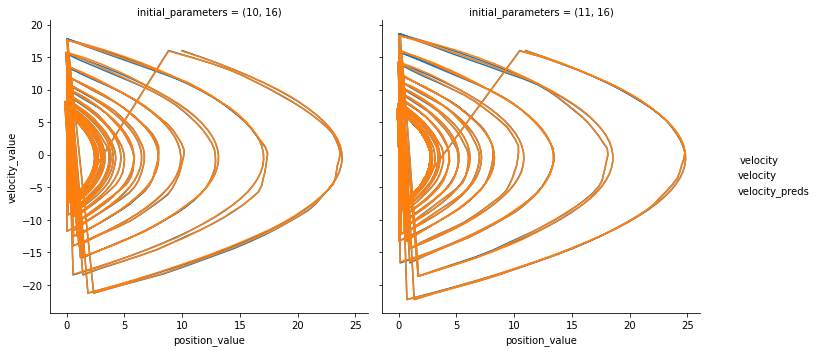

In [22]:
g = sns.FacetGrid(hue(training_and_predictions, ["position", "velocity"]), height = 5, col="initial_parameters", hue="velocity", col_wrap=2,)
g.map(plot, "position_value", "velocity_value", ci=None)
g.add_legend()

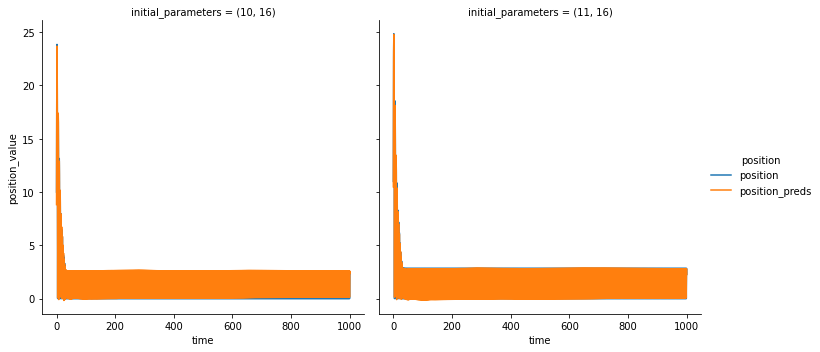

In [23]:
g = sns.FacetGrid(hue(training_and_predictions, ["position"]), col="initial_parameters", height = 5, hue="position", col_wrap=2,)
g.map(sns.lineplot, "time", "position_value")
g.add_legend()

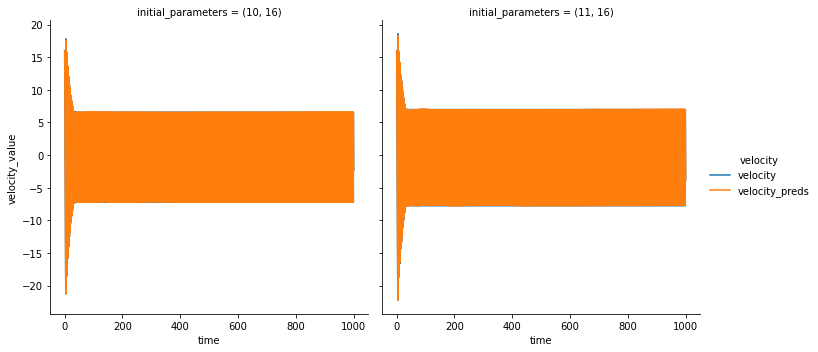

In [24]:
g = sns.FacetGrid(hue(training_and_predictions, ["velocity"]), col="initial_parameters", height = 5, hue="velocity", col_wrap=2,)
g.map(sns.lineplot, "time", "velocity_value", ci=None)
g.add_legend()

## Testing : Simulations

In [25]:
testing = pd.DataFrame(data = pd.read_csv("../../data/test/bouncing.csv"))

In [26]:
testing.head()

,time,initial_position,initial_velocity,position,velocity
0,0.0,11.45,16,11.4500,16.000
1,0.1,11.45,16,13.0500,15.019
2,0.2,11.45,16,14.5519,14.038
3,0.3,11.45,16,15.9557,13.057
4,0.4,11.45,16,17.2614,12.076


In [27]:
testing["initial_parameters"] = list(zip(testing.initial_position, testing.initial_velocity))
testing.head()

,time,initial_position,initial_velocity,position,velocity,initial_parameters
0,0.0,11.45,16,11.4500,16.000,"(11.45, 16)"
1,0.1,11.45,16,13.0500,15.019,"(11.45, 16)"
2,0.2,11.45,16,14.5519,14.038,"(11.45, 16)"
3,0.3,11.45,16,15.9557,13.057,"(11.45, 16)"
4,0.4,11.45,16,17.2614,12.076,"(11.45, 16)"


In [28]:
len(testing)

30003

## Testing : Predictions

In [29]:
def testing_preds(test_df):
    inputs = torch.tensor(test_df.iloc[ :, [0,1,2,4]].values)
    targets = torch.tensor(test_df.iloc[:, [3,4]].values)
    preds, _ = predictions(num_inputs=4, num_classes=2, learning_rate=0.0005, batch_size=1, num_epochs=1, inputs=inputs.float(), targets=targets.float(), train=False, path= "../../data/state/bouncing.pth")
    data = {'time' : test_df.time.values,
            'initial_parameters' : test_df.initial_parameters.values,
            'position' : tensor_flatten(preds[:,0]), 'velocity' : tensor_flatten(preds[:, 1])}
    return pd.DataFrame(data = data, columns = ["time", "position", "velocity", "initial_parameters",]);

In [30]:
testing_preds = testing_preds(testing)

In [31]:
len(testing_preds)

30003

In [32]:
testing_preds.head()

,time,position,velocity,initial_parameters
0,0.0,11.257423,15.926881,"(11.45, 16)"
1,0.1,13.139750,15.006834,"(11.45, 16)"
2,0.2,14.637382,14.071455,"(11.45, 16)"
3,0.3,16.057640,13.101649,"(11.45, 16)"
4,0.4,17.382881,12.117537,"(11.45, 16)"


In [33]:
testing_preds = testing_preds.rename(columns={"position" : "position_preds", "velocity" : "velocity_preds"})

In [34]:
testing_preds.head()

,time,position_preds,velocity_preds,initial_parameters
0,0.0,11.257423,15.926881,"(11.45, 16)"
1,0.1,13.139750,15.006834,"(11.45, 16)"
2,0.2,14.637382,14.071455,"(11.45, 16)"
3,0.3,16.057640,13.101649,"(11.45, 16)"
4,0.4,17.382881,12.117537,"(11.45, 16)"


In [35]:
testing_and_predictions = pd.merge(testing, testing_preds, right_on=["time", "initial_parameters"], left_on=["time", "initial_parameters"])

In [36]:
testing_and_predictions.head()

,time,initial_position,initial_velocity,position,velocity,initial_parameters,position_preds,velocity_preds
0,0.0,11.45,16,11.4500,16.000,"(11.45, 16)",11.257423,15.926881
1,0.1,11.45,16,13.0500,15.019,"(11.45, 16)",13.139750,15.006834
2,0.2,11.45,16,14.5519,14.038,"(11.45, 16)",14.637382,14.071455
3,0.3,11.45,16,15.9557,13.057,"(11.45, 16)",16.057640,13.101649
4,0.4,11.45,16,17.2614,12.076,"(11.45, 16)",17.382881,12.117537


### Graphs

In [37]:
def hue(df, hue):
    for var in hue:
        columns = list(df.columns)
        columns.remove(var)
        columns.remove("{}_{}".format(var,"preds"))
        df = df.melt(columns, var_name=var, value_name = f"{var}value")
    return df

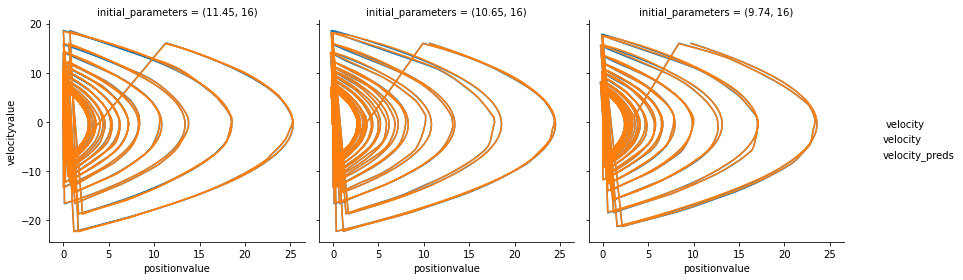

In [38]:
g = sns.FacetGrid(hue(testing_and_predictions, ["position", "velocity"]), col_wrap=3, height = 4, col="initial_parameters", hue="velocity")
g.map(plot, "positionvalue", "velocityvalue", ci=None)
g.add_legend()

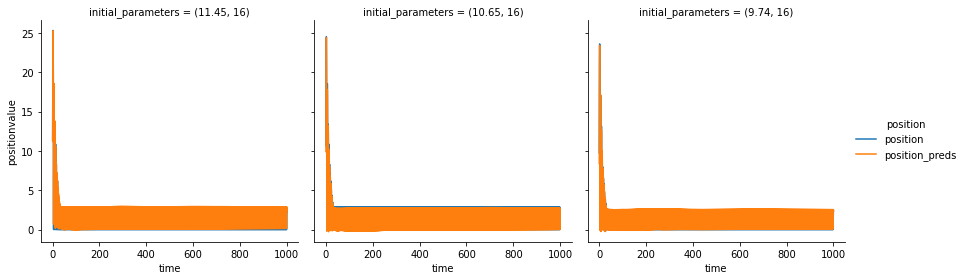

In [39]:
g = sns.FacetGrid(hue(testing_and_predictions, ["position"]), col_wrap=3, height = 4, col="initial_parameters", hue="position")
g.map(sns.lineplot, "time", "positionvalue", ci=None)
g.add_legend()

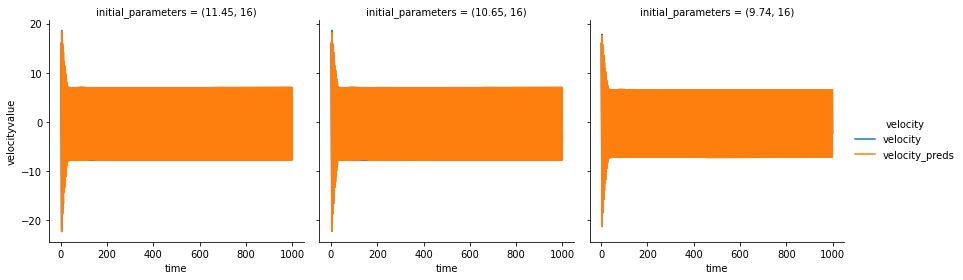

In [40]:
g = sns.FacetGrid(hue(testing_and_predictions, ["velocity"]), col_wrap=3, height = 4, col="initial_parameters", hue="velocity")
g.map(sns.lineplot, "time", "velocityvalue", ci=None)
g.add_legend()

### Loss by simulation

In [41]:
testing.head()

,time,initial_position,initial_velocity,position,velocity,initial_parameters
0,0.0,11.45,16,11.4500,16.000,"(11.45, 16)"
1,0.1,11.45,16,13.0500,15.019,"(11.45, 16)"
2,0.2,11.45,16,14.5519,14.038,"(11.45, 16)"
3,0.3,11.45,16,15.9557,13.057,"(11.45, 16)"
4,0.4,11.45,16,17.2614,12.076,"(11.45, 16)"


In [42]:
testing_cpy = testing.copy()

In [43]:
testing_cpy = testing_cpy.drop(columns=["initial_position","initial_velocity"])

In [44]:
testing_cpy.head()

,time,position,velocity,initial_parameters
0,0.0,11.4500,16.000,"(11.45, 16)"
1,0.1,13.0500,15.019,"(11.45, 16)"
2,0.2,14.5519,14.038,"(11.45, 16)"
3,0.3,15.9557,13.057,"(11.45, 16)"
4,0.4,17.2614,12.076,"(11.45, 16)"


In [45]:
testing_preds.head()

,time,position_preds,velocity_preds,initial_parameters
0,0.0,11.257423,15.926881,"(11.45, 16)"
1,0.1,13.139750,15.006834,"(11.45, 16)"
2,0.2,14.637382,14.071455,"(11.45, 16)"
3,0.3,16.057640,13.101649,"(11.45, 16)"
4,0.4,17.382881,12.117537,"(11.45, 16)"


In [46]:
simulationLoss, _ = lossBySimulations(testing_cpy, testing_preds, [1,2])

In [47]:
simulationLoss.head()

,initial_parameters,Loss
0,9.74 16,0.003055
1,10.65 16,0.011263
2,11.45 16,0.004085


In [48]:
initial_values = (np.array([10.65, 11.45, 9.74]), np.array([16,15.999999,16]))

In [49]:
simulationLossDistance = lossBySimulationsDistance(simulationLoss, initial_values)

In [50]:
simulationLossDistance.head()

,initial_parameters,Loss,Distance
1,10.65 16,0.011263,0.668501
2,11.45 16,0.004085,1.311279
0,9.74 16,0.003055,1.354125


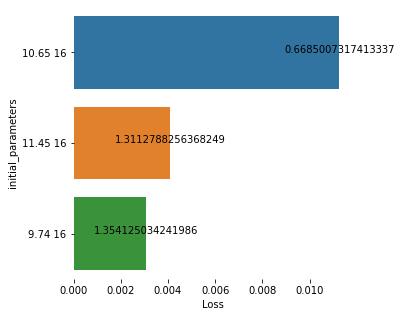

In [51]:
simulaPlots("Loss", "initial_parameters", simulationLossDistance, figsize = (5,5))

In [52]:
timeLoss, _ = lossByTime(testing_cpy, testing_preds, [1,2])

In [53]:
timeLoss.head()

,Time,initial_parameters,Loss
0,0.0,"(9.74, 16)",0.921072
1,0.1,"(9.74, 16)",0.544101
2,0.2,"(9.74, 16)",0.246756
3,0.3,"(9.74, 16)",0.140131
4,0.4,"(9.74, 16)",0.200858


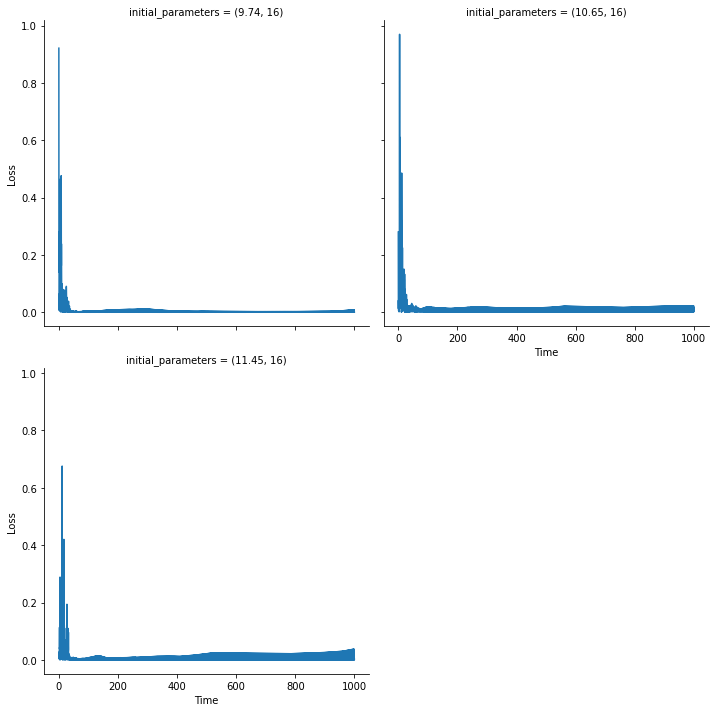

In [54]:
g = sns.FacetGrid(data = timeLoss, col = "initial_parameters", height = 5, col_wrap=2)
g.map(sns.lineplot, "Time", "Loss", ci=None)
g.add_legend()

In [55]:
individualTimeLoss = timeLoss.groupby("Time").sum("Loss").reset_index()

<AxesSubplot:xlabel='Time', ylabel='Loss'>

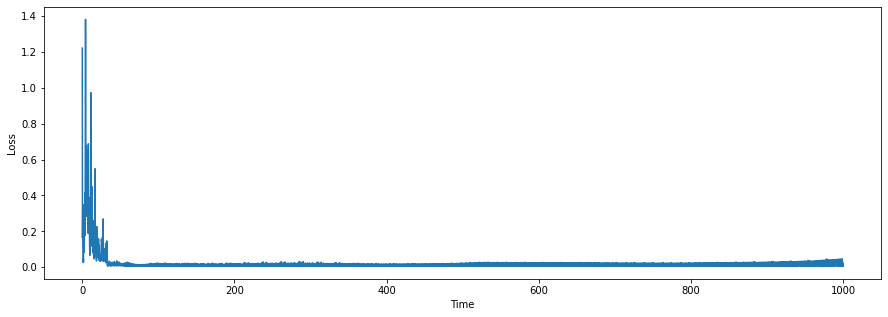

In [56]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data = individualTimeLoss, x = "Time", y = "Loss", ax = ax )

<AxesSubplot:>

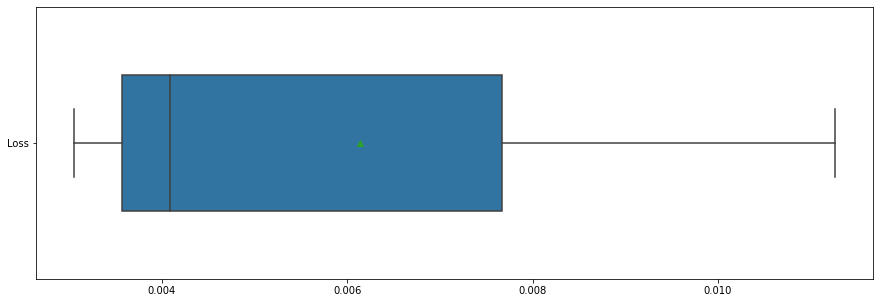

In [57]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data = simulationLossDistance[["Loss"]], showmeans=True, orient="h", width = 0.5,ax=ax)

(20.0, 30.0)

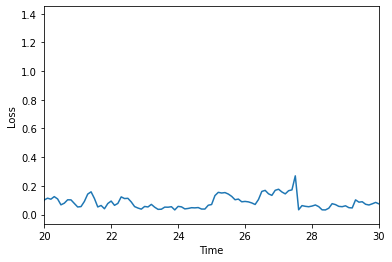

In [69]:
fig, ax = plt.subplots()
sns.lineplot(data = individualTimeLoss, x = "Time", y = "Loss", ax = ax )
ax.set_xlim(20,30)